In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from matplotlib.animation import FuncAnimation
from scipy.linalg import solve_banded
from IPython.display import HTML 
import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 2**128

## 9.8: The Schrödinger equation and the Crank-Nicolson method


### Background
The Schrödinger equation in one dimension for a particle of mass $M$ with no potential energy reads:

$$-\frac{\hbar^2}{2M} \frac{\partial^2\psi}{\partial x^2} = i\hbar \frac{\partial\psi}{\partial t}$$

For simplicity, let's put our particle in a box with impenetrable walls, so that we only have to solve the equation in a finite-sized space. The box forces the wavefunction $\psi$ to be zero at the walls, which we'll put at $x = 0$ and $x = L$.

Using the Crank-Nicolson method, the equation can be written in the matrix form:

$$\mathbf{A}\psi(t+h) = \mathbf{B}\psi(t)$$

where $\psi(t)$ is the vector of values of $\psi$ at the grid points $a, 2a, 3a, \dots$ at time $t$. The matrices $\mathbf{A}$ and $\mathbf{B}$ are both symmetric and tridiagonal:

$$
\mathbf{A} = \begin{pmatrix}
a_1 & a_2 & & & \\
a_2 & a_1 & a_2 & & \\
& a_2 & a_1 & a_2 & \\
& & \ddots & \ddots & \ddots
\end{pmatrix}, \quad
\mathbf{B} = \begin{pmatrix}
b_1 & b_2 & & & \\
b_2 & b_1 & b_2 & & \\
& b_2 & b_1 & b_2 & \\
& & \ddots & \ddots & \ddots
\end{pmatrix}
$$

with coefficients:

$$a_1 = 1 + h \frac{i\hbar}{2ma^2}, \quad a_2 = -h \frac{i\hbar}{4ma^2}$$
$$b_1 = 1 - h \frac{i\hbar}{2ma^2}, \quad b_2 = h \frac{i\hbar}{4ma^2}$$

Note the different signs and the factors of 2 and 4 in the denominators.

### Problem Setup
Consider an electron (mass $M = 9.109 \times 10^{-31}$ kg) in a box of length $L = 10^{-8}$ m. Suppose that at time $t=0$ the wavefunction of the electron has the form:

$$\psi(x, 0) = \exp \left[ -\frac{(x-x_0)^2}{2\sigma^2} \right] e^{i\kappa x}$$

where:
* $x_0 = \frac{L}{2}$
* $\sigma = 1 \times 10^{-10}$ m
* $\kappa = 5 \times 10^{10}$ m$^{-1}$
* $\psi = 0$ on the walls at $x=0$ and $x=L$.

---

### Part (a)
Write a program to perform a single step of the Crank-Nicolson method for this electron, calculating the vector $\psi(t)$ of values of the wavefunction, given the initial wavefunction above and using $N=1000$ spatial slices with $a = L/N$. Your program will have to perform the following steps:

1.  Given the vector $\psi(0)$ at $t=0$, multiply by the matrix $\mathbf{B}$ to get a vector $\mathbf{v} = \mathbf{B}\psi$. Because of the tridiagonal form of $\mathbf{B}$, the $i$-th component of $\mathbf{v}$ is given by:
    $$v_i = b_1 \psi_i + b_2(\psi_{i+1} + \psi_{i-1})$$
2.  Solve the linear system $\mathbf{Ax} = \mathbf{v}$ for $\mathbf{x}$, which gives the new value of $\psi$.
    * *Note:* Since $\mathbf{A}$ is tridiagonal, use a fast solver for banded matrices (e.g., `scipy.linalg.solve_banded` or the `banded.py` file provided in textbook resources).

**Time-step:** A reasonable choice is $h = 10^{-18}$ s.

Once you have the code in place to perform a single step, extend your program to perform repeated steps and solve for $\psi$ at a sequence of times a separation $h$ apart. Note that the matrix $\mathbf{A}$ is independent of time, so you can set it up just once.

### Part (b)
Extend your program to make an animation of the solution by displaying the real part of the wavefunction at each time-step.

### Part (c)
Run your animation for a while and describe what you see. Write a few sentences explaining in physics terms what is going on in the system.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
from matplotlib.animation import FuncAnimation
from scipy.linalg import solve_banded
from IPython.display import HTML 
import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 2**128

# Constants
M = 9.109e-31       
L = 1.0e-8        
hbar = 1.05457e-34
sigma = 1.0e-10 
kappa = 5.0e10   
x0 = L / 2       

# params
N = 1000            
a = L / N           
h = 1.0e-18         
steps_per_frame = 20 


const_factor = (1j * hbar) / (2 * M * a**2)

a1 = 1 + h * const_factor
a2 = -h * const_factor / 2
b1 = 1 - h * const_factor
b2 = h * const_factor / 2

size = N - 1
A_banded = np.zeros((3, size), dtype=complex)
A_banded[0, 1:] = a2  # upper diagonal
A_banded[1, :]  = a1  # main diagonal
A_banded[2, :-1]= a2  # lower diagonal

x = np.linspace(0, L, N+1)
psi = np.exp(-((x - x0)**2) / (2 * sigma**2)) * np.exp(1j * kappa * x)
psi[0] = 0
psi[N] = 0

#--

def update_psi(psi_current):
    # One step of CN
    
    # calculate v=B*psi
    psi_inner = psi_current[1:N]
    psi_left  = psi_current[0:N-1]
    psi_right = psi_current[2:N+1]
    
    v = b1 * psi_inner + b2 * (psi_right + psi_left)
    
    # solve A*psi = v
    psi_new_inner = solve_banded((1, 1), A_banded, v)
    
    # update
    psi_next = np.zeros_like(psi_current)
    psi_next[1:N] = psi_new_inner
    
    return psi_next

# animation
fig, ax = plt.subplots(figsize=(10, 6))
line, = ax.plot(x, np.real(psi), label='Real($\psi$)', color="cornflowerblue")
ax.set_ylim(-1, 1)
ax.set_xlim(0, L)
ax.set_xlabel('Position x [m]')
ax.set_ylabel('Wavefunction $\psi$')
ax.set_title('Electron in 1D Box')
ax.legend()
time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)

def init():
    line.set_ydata(np.ma.array(x, mask=True))
    time_text.set_text('')
    return line, time_text
def animate(frame):
    global psi
    # multiple steps per frame
    for _ in range(steps_per_frame):
        psi = update_psi(psi)
    line.set_ydata(np.real(psi))
    current_time = frame * steps_per_frame * h
    time_text.set_text(f'Time = {current_time:.2e} s')
    
    return line, time_text

ani = FuncAnimation(fig, animate, init_func=init, frames=600, interval=30, blit=True)

ani.save('schrodinger_evolution.gif', writer='pillow', fps=30)

#plt.close()   
#HTML(ani.to_jshtml())

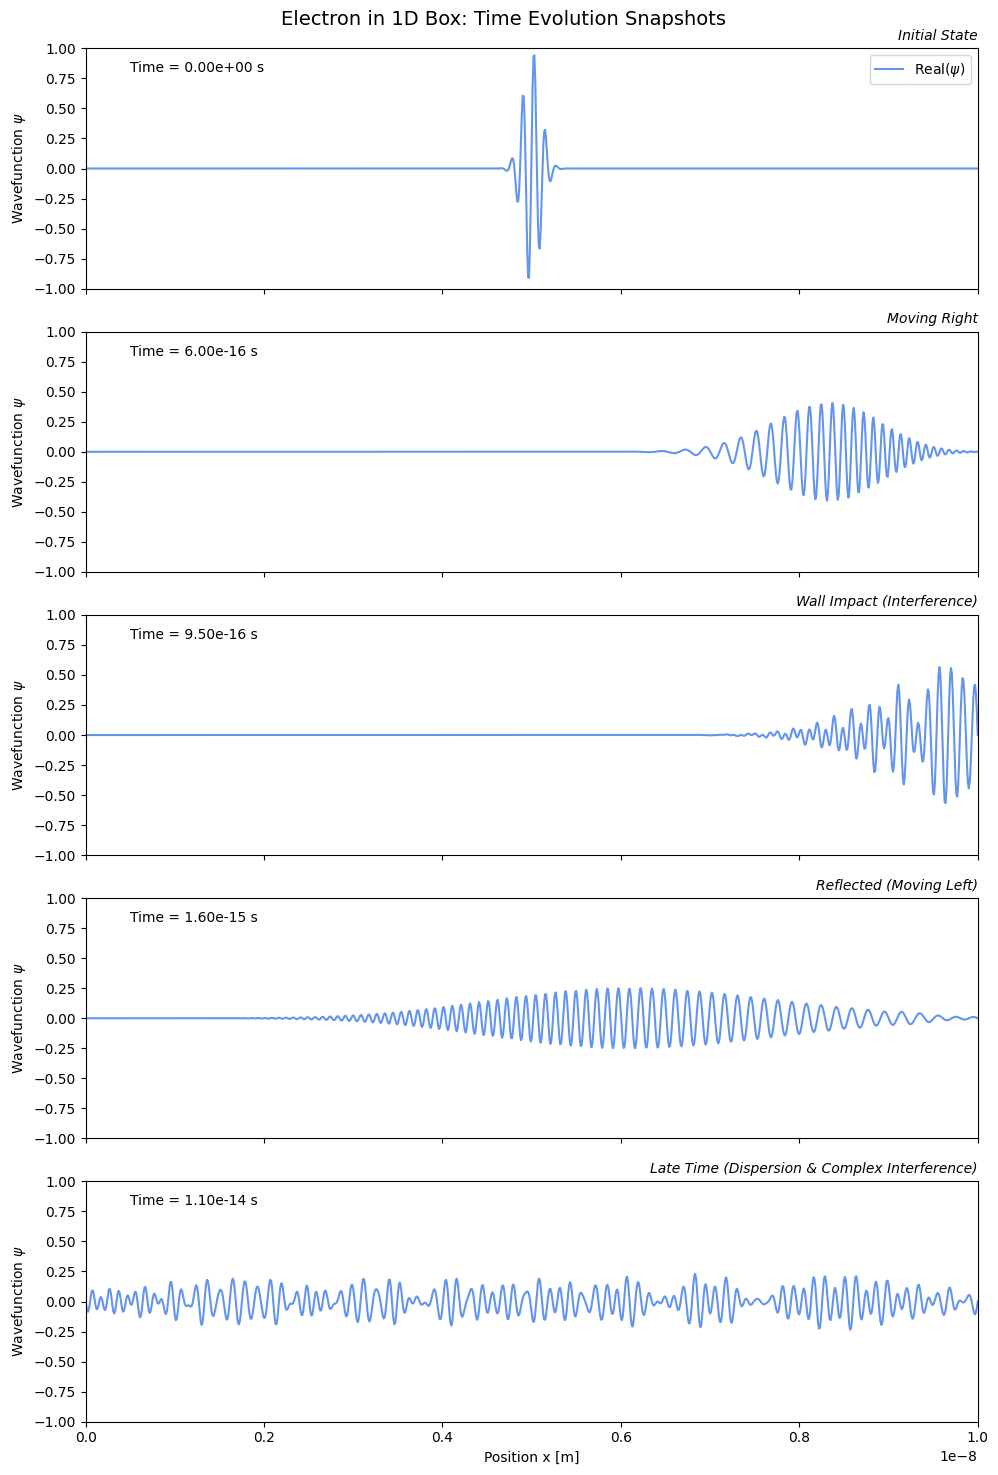

In [83]:
x = np.linspace(0, L, N+1)
psi = np.exp(-((x - x0)**2) / (2 * sigma**2)) * np.exp(1j * kappa * x)
psi[0] = 0
psi[N] = 0


#snapshots
capture_steps = [0, 600, 950, 1600, 11000]
titles = [
    "Initial State",
    "Moving Right",
    "Wall Impact (Interference)",
    "Reflected (Moving Left)",
    "Late Time (Dispersion & Complex Interference)"
]

snapshots = []
current_step = 0
max_step = max(capture_steps)

while current_step <= max_step:
    if current_step in capture_steps:
        snapshots.append((current_step, psi.copy()))
        
    psi = update_psi(psi)
    current_step += 1

    

fig, axes = plt.subplots(5, 1, figsize=(10, 15), sharex=True)

for i, ax in enumerate(axes):
    step, psi_snap = snapshots[i]
    time_val = step * h
    
    ax.plot(x, np.real(psi_snap), label='Real($\psi$)', color="cornflowerblue")
    
    ax.set_ylim(-1, 1)
    ax.set_xlim(0, L)
    ax.set_ylabel('Wavefunction $\psi$')
    
    ax.text(0.05, 0.9, f'Time = {time_val:.2e} s', transform=ax.transAxes)
    
    ax.set_title(titles[i], loc='right', fontsize=10, style='italic')
    
    if i == 0:
        ax.legend(loc='upper right')

# Set label only on the bottom plot
axes[-1].set_xlabel('Position x [m]')
fig.suptitle('Electron in 1D Box: Time Evolution Snapshots', fontsize=14)

plt.tight_layout()
plt.savefig('TEsnapshots.png', dpi=300) 
plt.show()

## 9.2 : Laplace's Equation and the Gauss-Seidel Method

### Problem Statement
Use the combined overrelaxation/Gauss-Seidel method to solve Laplace’s equation for the two-dimensional problem in Example 9.1—a square box $1 \text{ m}$ on each side, at voltage $V = 1 \text{ volt}$ along the top wall and zero volts along the other three.

**Requirements:**
* **Grid:** Use a grid of spacing $a = 1 \text{ cm}$, so that there are 100 grid points along each wall, or 101 if you count the points at both ends.
* **Convergence Condition:** Continue the iteration of the method until the value of the electric potential changes by no more than $\delta = 10^{-6} \text{ V}$ at any grid point on any step.
* **Output:** Make a density plot of the final solution, similar to that shown in Fig. 9.3.
* **Optimization:** Experiment with different values of $\omega$ to find which value gives the fastest solution. As mentioned in the text, you should find that a value around $0.9$ does well.
    * *Note:* In general larger values cause the calculation to run faster, but if you choose too large a value the speed drops off and for values above $1$ the calculation becomes unstable.

Solving with omega = 0.9...
Converged in 441 iterations.
Time taken: 0.17 seconds.


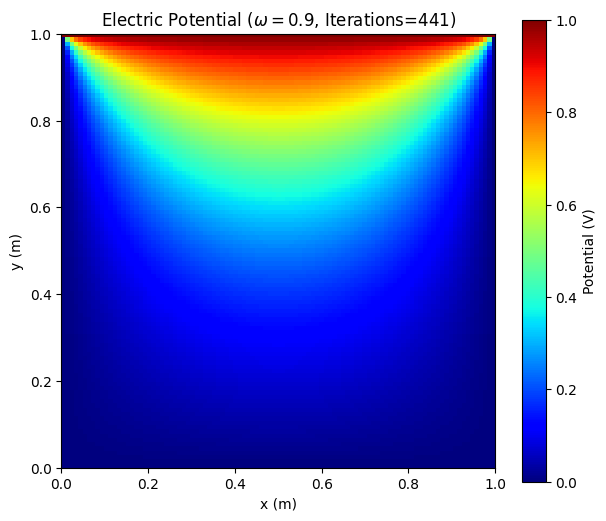


--- Omega vals ---
omega = 0.00 : 6071 iterations
omega = 0.50 : 2392 iterations
omega = 0.80 : 909 iterations
omega = 0.90 : 441 iterations
omega = 0.95 : 253 iterations


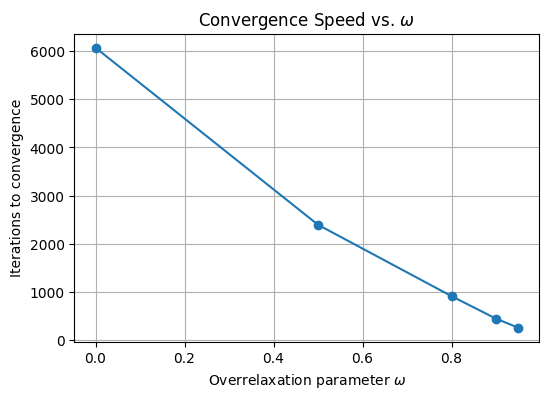

In [91]:
import numpy as np
import matplotlib.pyplot as plt
import time

# consts
M = 100         
V = 1.0         
target = 1e-6   

def solve_laplace(omega, M=M, V=V, target=target, max_iter=20000):
    # init grid
    phi = np.zeros([M + 1, M + 1], float)
    phi[0, :] = V  # bc top
    
    # masks for vectorization
    y, x = np.indices((M + 1, M + 1))
    mask_even = (x + y) % 2 == 0
    mask_odd  = (x + y) % 2 == 1
    
    # inner masks (strictly interior 1..M-1)
    inner_mask_even = mask_even & (x > 0) & (x < M) & (y > 0) & (y < M)
    inner_mask_odd  = mask_odd  & (x > 0) & (x < M) & (y > 0) & (y < M)
    
    iterations = 0
    delta = 1.0
    
    while delta > target and iterations < max_iter:
        phi_old = phi.copy()
        phi_avg = 0.25 * (phi[0:M-1, 1:M] + phi[2:M+1, 1:M] + 
                          phi[1:M, 0:M-1] + phi[1:M, 2:M+1])
        
        slice_mask_even = inner_mask_even[1:M, 1:M]
        change = (1 + omega) * (phi_avg - phi[1:M, 1:M])
        phi[1:M, 1:M][slice_mask_even] += change[slice_mask_even]
        #--
        phi_avg = 0.25 * (phi[0:M-1, 1:M] + phi[2:M+1, 1:M] + 
                          phi[1:M, 0:M-1] + phi[1:M, 2:M+1])
                slice_mask_odd = inner_mask_odd[1:M, 1:M]
        change = (1 + omega) * (phi_avg - phi[1:M, 1:M])
        phi[1:M, 1:M][slice_mask_odd] += change[slice_mask_odd]
        
        # check convergence
        delta = np.max(np.abs(phi - phi_old))
        iterations += 1
        
    return phi, iterations

# run with w=0.9
print("Solving with omega = 0.9...")
start_time = time.time()
phi_sol, iters = solve_laplace(0.9)
end_time = time.time()
print(f"Converged in {iters} iterations.")
print(f"Time taken: {end_time - start_time:.2f} seconds.")

# plot result
plt.figure(figsize=(7, 6))
plt.imshow(phi_sol, origin='upper', extent=[0, 1, 0, 1], cmap='jet')
plt.colorbar(label="Potential (V)")
plt.title(f"Electric Potential ($\\omega=0.9$, Iterations={iters})")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.show()

# omega vals
print("\n--- Omega vals ---")
omegas = [0.0, 0.5, 0.8, 0.9, 0.95]
results = []

for w in omegas:
    _, count = solve_laplace(w)
    results.append(count)
    print(f"omega = {w:.2f} : {count} iterations")

plt.figure(figsize=(6, 4))
plt.plot(omegas, results, 'o-')
plt.xlabel("Overrelaxation parameter $\\omega$")
plt.ylabel("Iterations to convergence")
plt.title("Convergence Speed vs. $\\omega$")
plt.grid(True)
plt.show()

# Homework Problem: Poisson's Equation with Relaxation


### Problem Description
You will use the relaxation method to solve for the potential of a series of charged particles. 

**Data:** A datafile named `particles.dat` contains a set of $(x,y)$ coordinates for a series of charged particles.
* **Charge:** All particles have charge equal to the electron charge $e$.
* **Range:** The coordinates range is $[0, 100]$.
* **Boundary:** The particles are placed in a box that is grounded (potential $V=0$) on all 4 sides.

### Tasks

**(a) Charge Density with Cloud-in-Cell**
Using the **cloud-in-cell** technique, assign the charges to a two-dimensional grid of size $[0, M]$ per side, with $M=100$.
* The centers of each grid cell $(i,j)$ are located at $(i+0.5, j+0.5)$.
* **Output:** Produce an image of the charge density field $\rho$.

**(b) Potential with Standard Relaxation**
Use the **standard relaxation method** to solve Poisson's equation:
$$\nabla^2\phi = -\frac{\rho}{\epsilon_0}$$
* **Output:** Produce an image showing the resulting potential field.
* **Convergence:** Note the number of iterations it takes to converge. The convergence criterion is that the maximum difference for any cell in the grid between the current and prior step is $\delta = 1.0 \times 10^{-10}$.

**(c) Gauss-Seidel Overrelaxation & Optimization**
Now use the **Gauss-Seidel overrelaxation method** to solve Poisson's equation.
* **Optimization:** Determine the optimal value of the overrelaxation parameter $\omega$, using a technique like **Golden Ratio Search**.
* **Precision:** Find the optimal $\omega$ to a precision of $0.001$.
* **Output:** Produce a plot showing how your answer for $\omega$ evolves with each step in your minimization process.

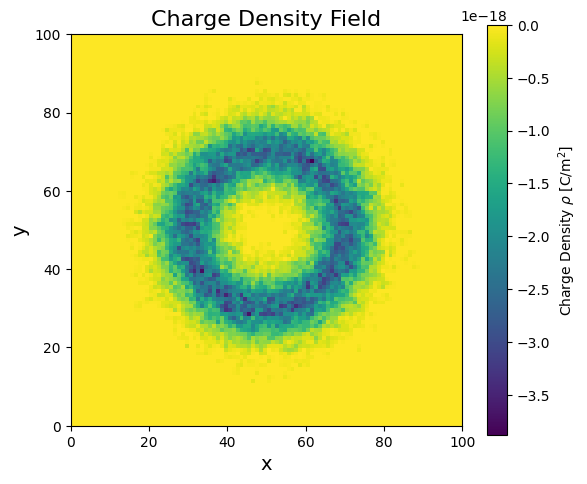

Running Part (b): Standard Relaxation (omega=0)...
Converged in 6745 iterations. Time: 3.16s


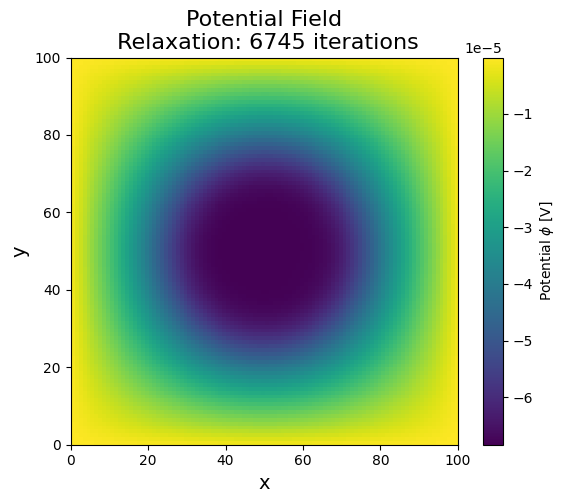


Running Part (c): Golden Ratio Search for Optimal Omega...
Range: [0.7181, 0.9900]
Range: [0.8219, 0.9900]
Range: [0.8861, 0.9900]
Range: [0.9258, 0.9900]
Range: [0.9258, 0.9655]
Range: [0.9258, 0.9503]
Range: [0.9352, 0.9503]
Range: [0.9352, 0.9445]
Range: [0.9387, 0.9445]
Range: [0.9410, 0.9445]
Range: [0.9410, 0.9432]
Range: [0.9418, 0.9432]
Range: [0.9423, 0.9432]

Optimal Omega found: 0.9427


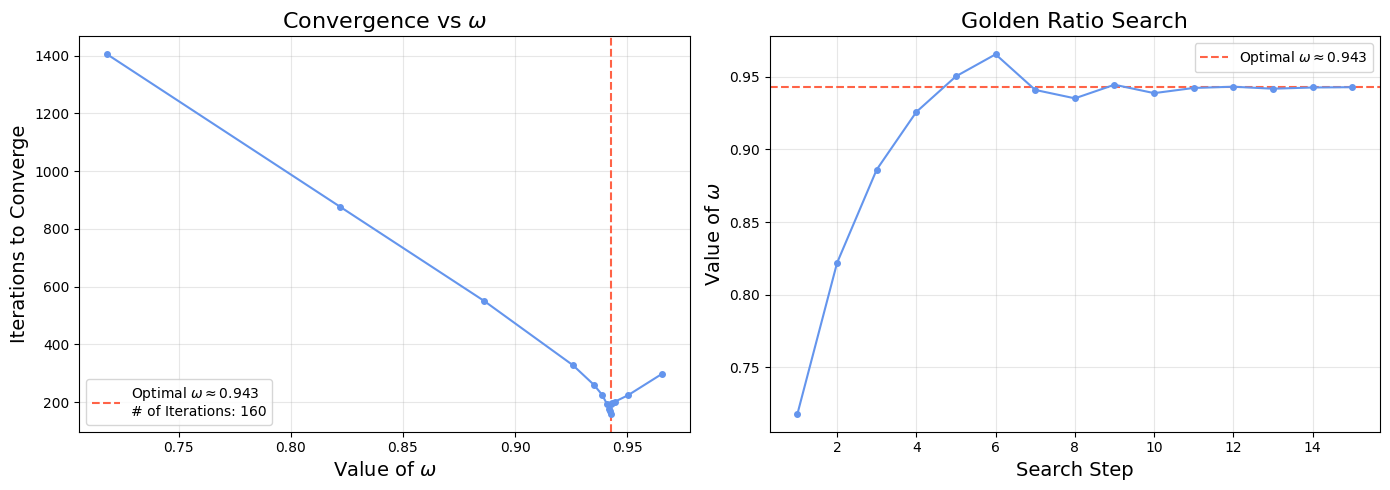

160


In [86]:
# Consts
M = 100              
L = 100.0            
a = L / M            
e_charge = -1.602e-19 
eps0 = 8.854e-12     
target = 1.0e-10     

particles = np.loadtxt('particles.dat')

def compute_density(particles, M, a):
    rho = np.zeros((M, M))
    
    # centers are at i+0.5, j+0.5.
    x_idx = (particles[:, 0] / a) - 0.5
    y_idx = (particles[:, 1] / a) - 0.5
    
    for k in range(len(particles)):
        i = int(np.floor(x_idx[k]))
        j = int(np.floor(y_idx[k]))
        
        dx = x_idx[k] - i
        dy = y_idx[k] - j
        
        if 0 <= i < M-1 and 0 <= j < M-1:
            rho[j, i]     += e_charge * (1 - dx) * (1 - dy)
            rho[j, i+1]   += e_charge * dx * (1 - dy)
            rho[j+1, i]   += e_charge * (1 - dx) * dy
            rho[j+1, i+1] += e_charge * dx * dy
            
    rho /= (a**2) # just learned I could do this *0*
    return rho

rho = compute_density(particles, M, a)

#(a)
plt.figure(figsize=(6, 5))
plt.imshow(rho, origin='lower', extent=[0, 100, 0, 100], cmap='viridis')
plt.colorbar(label='Charge Density $\\rho$ [C/m$^2$]')

plt.title('Charge Density Field', fontsize=16)
plt.xlabel('x', fontsize=14)
plt.ylabel('y', fontsize=14)

plt.tight_layout()
plt.savefig('charge_density.png', dpi=300) 
plt.show()
#--
def solve_poisson_fast(rho, omega, target_diff, max_iter=20000):
    # gauss seidel solution
    phi = np.zeros((M, M))
    source_term = (rho * a**2) / eps0
    
    y, x = np.indices((M, M))
    mask_even = (x + y) % 2 == 0
    mask_odd  = (x + y) % 2 == 1
    
    iterations = 0
    diff = target + 1.0
    
    while diff > target and iterations < max_iter:
        phi_old = phi.copy()
        
        # padding for bc's
        phi_padded = np.pad(phi, 1, mode='constant', constant_values=0)
        
        # neighbors sum
        neighbors = (phi_padded[0:-2, 1:-1] + 
                     phi_padded[2:, 1:-1]   + 
                     phi_padded[1:-1, 0:-2] + 
                     phi_padded[1:-1, 2:])
        
        phi_ideal = 0.25 * (neighbors + source_term)
        change = (1 + omega) * (phi_ideal - phi)
        
        # even update
        phi[mask_even] += change[mask_even]
        
        # re-evaluate neighbors
        phi_padded = np.pad(phi, 1, mode='constant', constant_values=0)
        neighbors = (phi_padded[0:-2, 1:-1] + phi_padded[2:, 1:-1] + 
                     phi_padded[1:-1, 0:-2] + phi_padded[1:-1, 2:])
        phi_ideal = 0.25 * (neighbors + source_term)
        change = (1 + omega) * (phi_ideal - phi)
        
        # odd update
        phi[mask_odd] += change[mask_odd]
        
        diff = np.max(np.abs(phi - phi_old))
        iterations += 1
        
    return phi, iterations

# (b)
print("Running Part (b): Standard Relaxation (omega=0)...")
start_t = time.time()
phi_std, iters_std = solve_poisson_fast(rho, omega=0.0, target_diff=target)
print(f"Converged in {iters_std} iterations. Time: {time.time()-start_t:.2f}s")

plt.figure(figsize=(6, 5))
plt.imshow(phi_std, origin='lower', extent=[0, 100, 0, 100], cmap='viridis')
plt.colorbar(label='Potential $\phi$ [V]')

plt.title(f'Potential Field\n Relaxation: {iters_std} iterations', fontsize=16)
plt.xlabel('x', fontsize=14)
plt.ylabel('y', fontsize=14)

plt.tight_layout()
plt.savefig('potential_field.png', dpi=300) 
plt.show()


#(c)

def golden_ratio_search():
    print("\nRunning Part (c): Golden Ratio Search for Optimal Omega...")
    
    a_pt = 0.55
    b_pt = 0.99
    tol = 0.001
    
    phi_ratio = (1 + np.sqrt(5)) / 2 
    
    # 1. Initialize Points
    c_pt = b_pt - (b_pt - a_pt) / phi_ratio
    d_pt = a_pt + (b_pt - a_pt) / phi_ratio
    
    # 2. Pre-evaluate the initial two points
    _, iter_c = solve_poisson_fast(rho, c_pt, target, max_iter=5000)
    _, iter_d = solve_poisson_fast(rho, d_pt, target, max_iter=5000)
    
    # Start history with these two points
    history = [(c_pt, iter_c), (d_pt, iter_d)]
    
    while abs(b_pt - a_pt) > tol:
        if iter_c < iter_d:
            # The minimum is in the left interval [a, d]
            b_pt = d_pt
            d_pt = c_pt      # Old c becomes new d
            iter_d = iter_c  # REUSE result! No need to recalculate.
            
            # Calculate new c
            c_pt = b_pt - (b_pt - a_pt) / phi_ratio
            _, iter_c = solve_poisson_fast(rho, c_pt, target, max_iter=5000)
            
            # Record only the NEW point
            history.append((c_pt, iter_c))
            
        else:
            # The minimum is in the right interval [c, b]
            a_pt = c_pt
            c_pt = d_pt      # Old d becomes new c
            iter_c = iter_d  # REUSE result!
            
            # Calculate new d
            d_pt = a_pt + (b_pt - a_pt) / phi_ratio
            _, iter_d = solve_poisson_fast(rho, d_pt, target, max_iter=5000)
            
            # Record only the NEW point
            history.append((d_pt, iter_d))
            
        print(f"Range: [{a_pt:.4f}, {b_pt:.4f}]")

    optimal_omega = (b_pt + a_pt) / 2
    return optimal_omega, history

opt_w, history = golden_ratio_search()
print(f"\nOptimal Omega found: {opt_w:.4f}")

hist_w_sorted, hist_iter_sorted = zip(*sorted(history))
hist_w_chronological = [h[0] for h in history]
search_steps = range(1, len(history) + 1)
min_iters = min(hist_iter_sorted)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# optimization curve
ax1.axvline(opt_w, color='tomato', linestyle='--', label=f'Optimal $\omega \\approx {opt_w:.3f}$\n# of Iterations: {min_iters}')
ax1.plot(hist_w_sorted, hist_iter_sorted, 'o-', color='cornflowerblue', markersize=4)

ax1.set_xlabel('Value of $\omega$', fontsize=14)
ax1.set_ylabel('Iterations to Converge', fontsize=14)
ax1.set_title('Convergence vs $\omega$', fontsize=16)

ax1.grid(True, alpha=0.3)
ax1.legend()

# search path
ax2.axhline(opt_w, color='tomato', linestyle='--', label=f'Optimal $\omega \\approx {opt_w:.3f}$')
ax2.plot(search_steps, hist_w_chronological, 'o-', color='cornflowerblue', markersize=4)

ax2.set_xlabel('Search Step', fontsize=14)
ax2.set_ylabel('Value of $\omega$', fontsize=14)
ax2.set_title('Golden Ratio Search', fontsize=16)

ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.savefig('omega_optimization.png', dpi=300) 
plt.show()

print(min_iters)

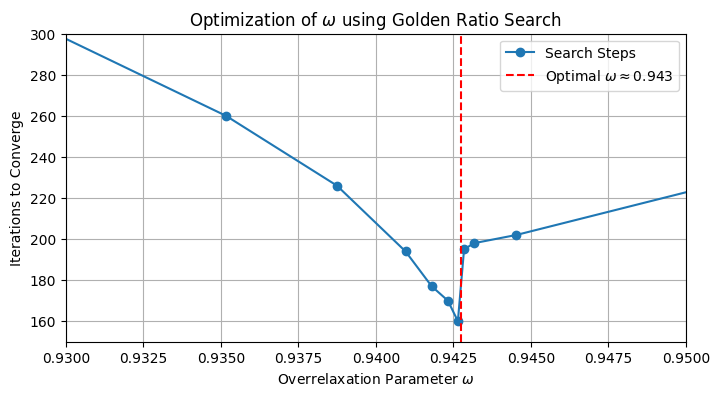

In [87]:
# Plot search history
hist_w, hist_iter = zip(*sorted(history))
plt.figure(figsize=(8, 4))
plt.plot(hist_w, hist_iter, 'o-', color='tab:blue', label='Search Steps')
plt.axvline(opt_w, color='r', linestyle='--', label=f'Optimal $\omega \\approx {opt_w:.3f}$')
plt.xlabel('Overrelaxation Parameter $\omega$')
plt.ylabel('Iterations to Converge')
plt.title('Optimization of $\omega$ using Golden Ratio Search')
plt.grid(True)
plt.xlim(0.93,0.95)
plt.ylim(150,300)
plt.legend()
plt.show()